In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Data Augmentation: Adding Noise and random masking

In [14]:
class RandomMaskNoise:
    def __init__(self, noise_factor=0.3, mask_prob=0.3):
        self.noise_factor = noise_factor
        self.mask_prob = mask_prob

    def __call__(self, img):
        img_np = np.array(img) # converting image -> numpy array
        mask = np.random.binomial(1, self.mask_prob, img_np.shape) #Creating Binary mask with prob
        noise = np.random.normal(scale=self.noise_factor, size=img_np.shape) # gaussian noise
        img_np = img_np * (1 - mask) + mask * (img_np + noise) # applying mask and noise
        return torch.tensor(img_np, dtype=torch.float32)

Fashion Mnist dataset

In [15]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Boilerplate Coding

In [17]:
# Autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

# Semi Supervised Autoencoder

class SSAE(nn.Module):
    def __init__(self):
        super(SSAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),  # Increased size
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),  # Increased size
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    # def semi_supervised_loss(self, inputs, outputs, labels, margin=0.2):
    #     # Standard reconstruction loss (per image)
    #     reconstruction_loss = F.mse_loss(outputs, inputs, reduction='none')  # Shape: [batch_size, 784]
    #     reconstruction_loss = reconstruction_loss.mean(dim=1)  # mean loss over pixels for each image
    #     # print("reconstruction_loss.shape: ", reconstruction_loss.shape)

    #     # Max-margin loss for labeled anomalies
    #     abnormal = labels > 0  # 1 for abnormal, 0 for normal
        
    #     # mean loss for abnormal samples (if there are any)
    #     # to avoid shape mismatch -> using the minimum size between reconstruction_loss and abnormal
    #     batch_size = reconstruction_loss.shape[0]
    #     abnormal_loss = reconstruction_loss[abnormal[:batch_size]].mean() if abnormal[:batch_size].any() else torch.tensor(0.0)
    #     # print("abnormal_loss: ", abnormal_loss.shape, abnormal_loss)

    #     return reconstruction_loss.mean() + abnormal_loss

    def semi_supervised_loss(self, inputs, outputs, labels, margin=0.2):
        # Calculate the standard reconstruction loss (per image)
        reconstruction_loss = F.mse_loss(outputs, inputs, reduction='none')  # Shape: [batch_size, 784]
        
        # Mean loss over pixels for each image
        reconstruction_loss = reconstruction_loss.mean(dim=1)  # Shape: [batch_size]
        
        # Identify the indices for abnormal samples
        abnormal = labels > 0  # Boolean mask: True for abnormal, False for normal
        
        # Handle the case where there are no abnormal samples
        if abnormal.any():
            # Calculate mean reconstruction loss for abnormal samples
            abnormal_loss = reconstruction_loss[abnormal].mean()
        else:
            # If no abnormal samples, set abnormal_loss to 0
            abnormal_loss = torch.tensor(0.0, device=inputs.device)

        # Average loss for all samples in the batch
        average_reconstruction_loss = reconstruction_loss.mean()

        # Return the total loss
        return average_reconstruction_loss + abnormal_loss



Initialize model =  Autoencoder(), loss and optimizer

In [18]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

training loop

In [6]:
train_losses = []

for epoch in range(10):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")
    epoch_loss = 0.0
    for images, _ in progress_bar:
        # print("images1: ", images)
        images = images.view(-1, 28*28)
        # print("images2: ", images)
        
        # Apply random mask and noise augmentation
        aug = RandomMaskNoise()(images)
        # print("aug: ", aug)
        
        # Forward pass
        outputs = model(aug)
        # print("Output: ", outputs)
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.item()

        # Update tqdm with loss value
        progress_bar.set_postfix(loss=loss.item())
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/10], Avg Loss: {avg_epoch_loss:.4f}")

Epoch 10/10: 100%|██████████| 938/938 [00:51<00:00, 18.13it/s, loss=0.00939]


In [ ]:
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 11), train_losses, marker='o', linestyle='-', color='b')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.xticks(np.arange(1, 11))
plt.grid()
plt.show()

 Let's visualize some result

In [19]:
def visualize_recons(images, augmented, outputs):
    fig, ax = plt.subplots(3, 6, figsize=(10, 8))
    for i in range(6):
        # Original image
        ax[0, i].imshow(images[i].reshape(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[0, i].set_title("Original")

        # Augmented (masked/noised) image
        ax[1, i].imshow(augmented[i].reshape(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[1, i].set_title("Masked/Noised")

        # Reconstructed image
        ax[2, i].imshow(outputs[i].reshape(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[2, i].set_title("Reconstructed")
    
    plt.tight_layout()
    plt.show()

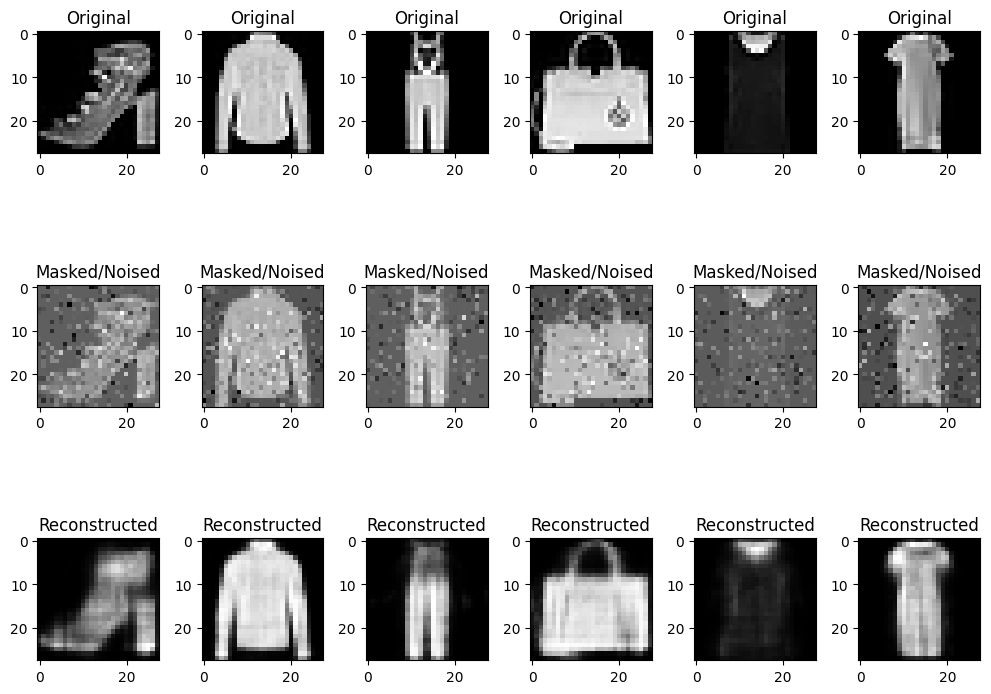

In [8]:
# Test and visualize original, augmented, and reconstructed images
with torch.no_grad():
    for images, _ in train_loader:
        images = images.view(-1, 28*28)
        augmented_images = RandomMaskNoise()(images)  # Apply mask and noise
        outputs = model(augmented_images)  # Reconstruct
        
        # Visualize
        visualize_recons(images, augmented_images, outputs)
        break

Initialize model = SSAE()

In [20]:
model2 = SSAE()

# batch_size = images.size(0)
# print(batch_size)
labels = torch.randint(0, 2, (32,)) # Random labels: 0 for normal, 1 for abnormal, BS = 64

training loop for SSAE

In [22]:
train_losses_ssae = []

for epoch in range(10):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10 (SSAE)")
    epoch_loss = 0.0  # Reset epoch loss for each epoch
    for images, _ in progress_bar:
        images = images.view(-1, 28*28)
        
        # Apply random mask and noise augmentation
        aug = RandomMaskNoise()(images)
        
        # Forward pass
        outputs = model2(aug)
        
        # Compute loss with semi-supervised learning
        loss1 = model2.semi_supervised_loss(images, outputs, labels)

        # print(f"Batch Loss: {loss.item():.6f}")  # Log batch loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()

        # Update tqdm with loss value
        progress_bar.set_postfix(loss=loss1.item())
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses_ssae.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/10], Avg Loss: {avg_epoch_loss:.4f}")

Epoch 1/10 (SSAE): 100%|██████████| 1875/1875 [00:31<00:00, 59.41it/s, loss=0.33] 


Epoch [1/10], Avg Loss: 0.0000


Epoch 2/10 (SSAE):  76%|███████▌  | 1417/1875 [00:23<00:07, 59.30it/s, loss=0.357]


KeyboardInterrupt: 

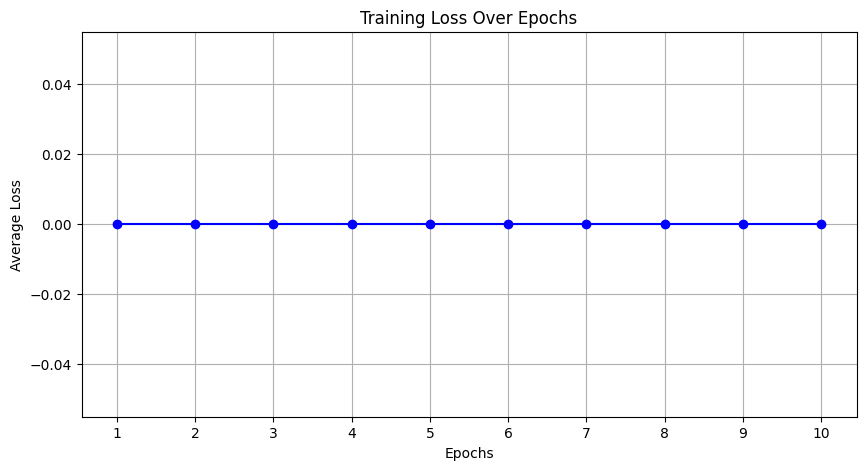

In [8]:
# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 11), train_losses_ssae, marker='o', linestyle='-', color='b')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.xticks(np.arange(1, 11))
plt.grid()
plt.show()

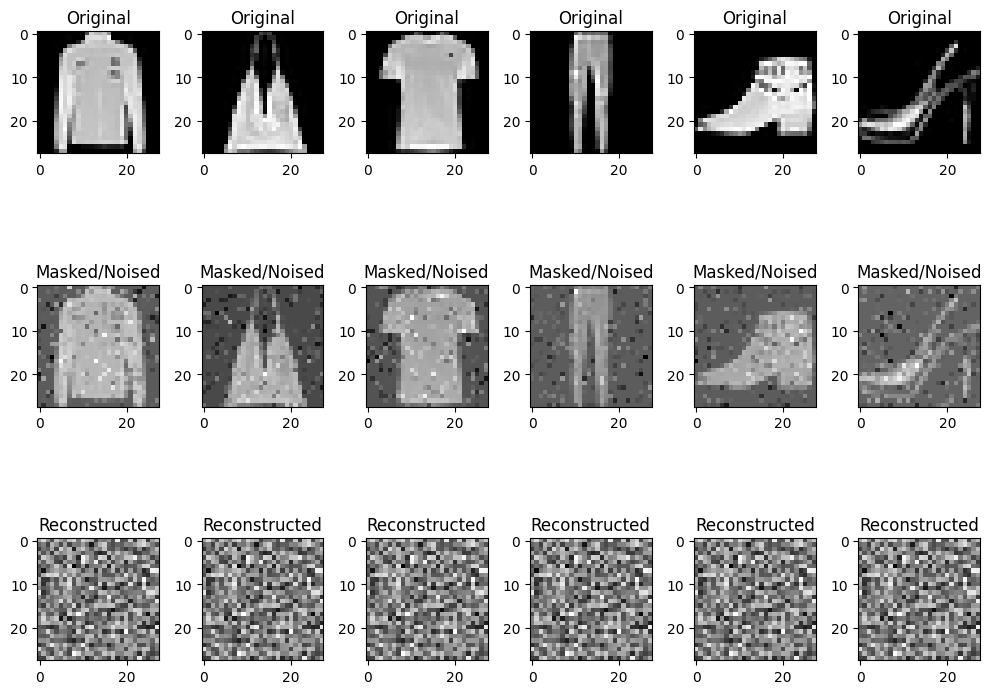

In [11]:
# Test and visualize original, augmented, and reconstructed images
with torch.no_grad():
    for images, _ in train_loader:
        images = images.view(-1, 28*28)
        augmented_images = RandomMaskNoise()(images)  # Apply mask and noise
        outputs = model2(augmented_images)  # Reconstruct
        
        # Visualize
        visualize_recons(images, augmented_images, outputs)
        break